# Clustering Part

objective: clustering zone by behavior of energy consumption

Energy counsumption clustered by zone should be determined by Energy consumption behavior
1. energy consumption behavior
2. energy needs

---

## Load Data

In [14]:
import numpy as np
import pandas as pd
import ee_functions as ee
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import pickle
import seaborn as sns

from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [73]:
dataset_list = [ee.make_data_sample(floor=i) for i in range(1, 8)]

In [76]:
# model = pickle.load(open('./model/model_lgbm_tuned.pickle', 'rb'))
model = MultiOutputRegressor(LGBMRegressor())

In [ ]:
# del temp_pred

In [77]:
final_df = pd.DataFrame()
count_zone = 0

for i, e in enumerate(dataset_list):
    floor_zone = ee.sep_zone(e)
    for key, value in floor_zone.items():
        count_zone += 1
        print(f"processing on... floor: {int(i)+1} / zone: {key} -- total: {count_zone} zone(s)")
        selected_zone, cols_name = ee.choose_zone(floor_zone, [key])
        df = e[cols_name]
        df = ee.reduce_resolution(df, interval=15)
        # imputer_knn_transformer = FunctionTransformer(ee.imputer_knn, kw_args={'zone': selected_zone})
        # df_sample = imputer_knn_transformer.fit_transform(df)
        imputer_iterative_transformer = FunctionTransformer(ee.imputer_iterative, kw_args={'zone': selected_zone})
        df_sample = imputer_iterative_transformer.fit_transform(df)
        df_temp = df_sample[df_sample['year'] == 2018]\
            .drop(columns=['quarter', 'year', 'dayofmonth', 'dayofyear', 'weekofyear', 'SMA30', 'SMA15', 'SMA7'])
        dict_transformed = {}
        features = ['degC_mean', 'RH%_mean', 'lux_mean', 'sum_ac', 'sum_light', 'sum_plug', 'sum_power', 
                    'sum_ac_nextyear', 'sum_light_nextyear', 'sum_plug_nextyear', 'sum_power_nextyear']
        for ix, feature in enumerate(features):
            if 'mean' in feature:
                try:
                    dict_transformed[feature] = df_temp[[col for col in df_sample.columns if feature.split(sep="_")[0] in col][0]].mean()
                except:
                    dict_transformed[feature] = np.nan
            elif 'nextyear' in feature:
                if 'temp_pred' not in locals():
                    X, y = ee.sep_input_output(df_sample)
                    X = ee.set_date_as_index(X)
                    y = ee.set_date_as_index(y)

                    df_test = df_sample[df_sample['year'] == 2019]
                    X_test, y_test = ee.sep_input_output(df_test)
                    X_test = ee.set_date_as_index(X_test)
                    y_test = ee.set_date_as_index(y_test)
                    print('fitting model...')
                    model.fit(X, y)
                    # verbosity
                    
                    temp_pred = model.predict(X_test)
                    metrics = ee.make_predict_score(y_test, temp_pred)
                    print(f"R2: {metrics[0]}, MSE: {metrics[1]}, MAE: {metrics[2]}")

                if 'ac' in feature:
                    try:
                        dict_transformed[feature] = temp_pred[:, 0].sum()
                    except:
                        dict_transformed[feature] = np.nan
                elif 'light' in feature:
                    try:
                        dict_transformed[feature] = temp_pred[:, 1].sum()
                    except:
                        dict_transformed[feature] = np.nan
                elif 'plug' in feature:
                    try:
                        dict_transformed[feature] = temp_pred[:, 2].sum()
                    except:
                        dict_transformed[feature] = np.nan
                elif 'power' in feature:
                    try:
                        dict_transformed[feature] = temp_pred[:, 3].sum()
                    except:
                        dict_transformed[feature] = np.nan
            else:
                try:
                    dict_transformed[feature] = [df_temp[x].sum() for x in df_temp.columns if feature in x][0]
                except:
                    dict_transformed[feature] = np.nan
        final_df = pd.concat([final_df, pd.DataFrame(dict_transformed, index=[0])], axis=0).reset_index(drop=True)
    del temp_pred

processing on... floor: 1 / zone: z1 -- total: 1 zone(s)
fitting model...
R2: 0.8494, MSE: 8.0976, MAE: 1.24
processing on... floor: 1 / zone: z2 -- total: 2 zone(s)
processing on... floor: 1 / zone: z3 -- total: 3 zone(s)
processing on... floor: 1 / zone: z4 -- total: 4 zone(s)
processing on... floor: 2 / zone: z1 -- total: 5 zone(s)
fitting model...
R2: 0.9855, MSE: 2.3361, MAE: 0.5223
processing on... floor: 2 / zone: z2 -- total: 6 zone(s)
processing on... floor: 2 / zone: z3 -- total: 7 zone(s)
processing on... floor: 2 / zone: z4 -- total: 8 zone(s)
processing on... floor: 3 / zone: z1 -- total: 9 zone(s)
fitting model...
R2: 0.9481, MSE: 2.1132, MAE: 0.4728
processing on... floor: 3 / zone: z2 -- total: 10 zone(s)
processing on... floor: 3 / zone: z3 -- total: 11 zone(s)
processing on... floor: 3 / zone: z4 -- total: 12 zone(s)
processing on... floor: 3 / zone: z5 -- total: 13 zone(s)
processing on... floor: 4 / zone: z1 -- total: 14 zone(s)
fitting model...
R2: 0.9784, MSE: 1.7

In [90]:
zone_list = []
for i, e in enumerate(dataset_list):
    zone = ee.sep_zone(e)
    for k in zone.keys():
        zone_list.append(f"floor{i+1}_{k}")

In [ ]:
final_df.insert(loc=0, value=zone_list, column='location')

In [82]:
final_df.to_parquet("df_clustering_pre.parquet")
final_df

,location,degC_mean,RH%_mean,lux_mean,sum_ac,sum_light,sum_plug,sum_power,sum_ac_nextyear,sum_light_nextyear,sum_plug_nextyear,sum_power_nextyear
0,floor1_z1,NaN,NaN,NaN,0.000000,112752.118021,73831.871424,1.865840e+05,0.000000,223065.787561,54505.483784,278276.559167
1,floor1_z2,NaN,NaN,NaN,596616.103329,260201.601561,274167.557039,1.130985e+06,0.000000,223065.787561,54505.483784,278276.559167
2,floor1_z3,NaN,NaN,NaN,0.000000,416407.807222,20560.448874,4.369683e+05,0.000000,223065.787561,54505.483784,278276.559167
3,floor1_z4,NaN,NaN,NaN,0.000000,302137.521313,0.000000,3.021375e+05,0.000000,223065.787561,54505.483784,278276.559167
4,floor2_z1,25.344855,59.686863,28.292708,148711.397690,52662.818664,19206.692538,2.205809e+05,297798.519249,89970.119809,39091.375534,426910.892637
5,floor2_z2,26.573877,63.688610,23.462590,185757.062508,11180.733952,3356.450571,2.002942e+05,297798.519249,89970.119809,39091.375534,426910.892637
6,floor2_z3,28.194350,64.099893,2.373539,0.000000,9110.824076,6705.630358,1.581645e+04,297798.519249,89970.119809,39091.375534,426910.892637
7,floor2_z4,23.993496,63.510199,16.580911,48066.613805,12201.777703,0.461729,6.026885e+04,297798.519249,89970.119809,39091.375534,426910.892637
8,floor3_z1,26.434646,59.880090,11.923335,76812.409483,29016.405186,4169.843952,1.099987e+05,169874.273050,61187.116420,8815.760938,239872.009655
9,floor3_z2,25.980274,60.686979,26.539486,55289.633399,34715.598631,4845.928942,9.485116e+04,169874.273050,61187.116420,8815.760938,239872.009655


In [83]:
from sklearn.impute import KNNImputer

In [87]:
imputer_2nd = KNNImputer(n_neighbors=3, weights='uniform')
array_temp = imputer_2nd.fit_transform(final_df.drop(columns=['location']))
df_clustering = pd.DataFrame(array_temp, columns=final_df.drop(columns=['location']).columns)

In [92]:
df_clustering.insert(loc=0, value=zone_list, column='location')

In [5]:
# df_clustering.to_parquet("df_clustering.parquet")
df_clustering = pd.read_parquet("./data_sample/df_clustering.parquet")
df_clustering

,location,degC_mean,RH%_mean,lux_mean,sum_ac,sum_light,sum_plug,sum_power,sum_ac_nextyear,sum_light_nextyear,sum_plug_nextyear,sum_power_nextyear
0,floor1_z1,26.113270,61.805960,23.278772,0.000000,112752.118021,73831.871424,1.865840e+05,0.000000,223065.787561,54505.483784,278276.559167
1,floor1_z2,25.830945,62.775074,19.655512,596616.103329,260201.601561,274167.557039,1.130985e+06,0.000000,223065.787561,54505.483784,278276.559167
2,floor1_z3,25.571807,64.222105,20.713771,0.000000,416407.807222,20560.448874,4.369683e+05,0.000000,223065.787561,54505.483784,278276.559167
3,floor1_z4,25.551109,63.721931,18.421033,0.000000,302137.521313,0.000000,3.021375e+05,0.000000,223065.787561,54505.483784,278276.559167
4,floor2_z1,25.344855,59.686863,28.292708,148711.397690,52662.818664,19206.692538,2.205809e+05,297798.519249,89970.119809,39091.375534,426910.892637
5,floor2_z2,26.573877,63.688610,23.462590,185757.062508,11180.733952,3356.450571,2.002942e+05,297798.519249,89970.119809,39091.375534,426910.892637
6,floor2_z3,28.194350,64.099893,2.373539,0.000000,9110.824076,6705.630358,1.581645e+04,297798.519249,89970.119809,39091.375534,426910.892637
7,floor2_z4,23.993496,63.510199,16.580911,48066.613805,12201.777703,0.461729,6.026885e+04,297798.519249,89970.119809,39091.375534,426910.892637
8,floor3_z1,26.434646,59.880090,11.923335,76812.409483,29016.405186,4169.843952,1.099987e+05,169874.273050,61187.116420,8815.760938,239872.009655
9,floor3_z2,25.980274,60.686979,26.539486,55289.633399,34715.598631,4845.928942,9.485116e+04,169874.273050,61187.116420,8815.760938,239872.009655


In [22]:
# df_temp.groupby('hour')[[col for col in df_sample.columns if 'sum' in col]].mean()
# df_temp.groupby('dayofweek')[[col for col in df_sample.columns if 'sum' in col]].mean()

## Clustering

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [6]:
scaled_df = StandardScaler().fit_transform(df_clustering.drop(columns=['location']))

In [7]:
K_list = [k for k in range(33) if k > 1]
distortions = []

for k in K_list:
    model = KMeans(n_clusters=k, init='k-means++')
    model.fit(scaled_df)
    distortions.append(model.inertia_)

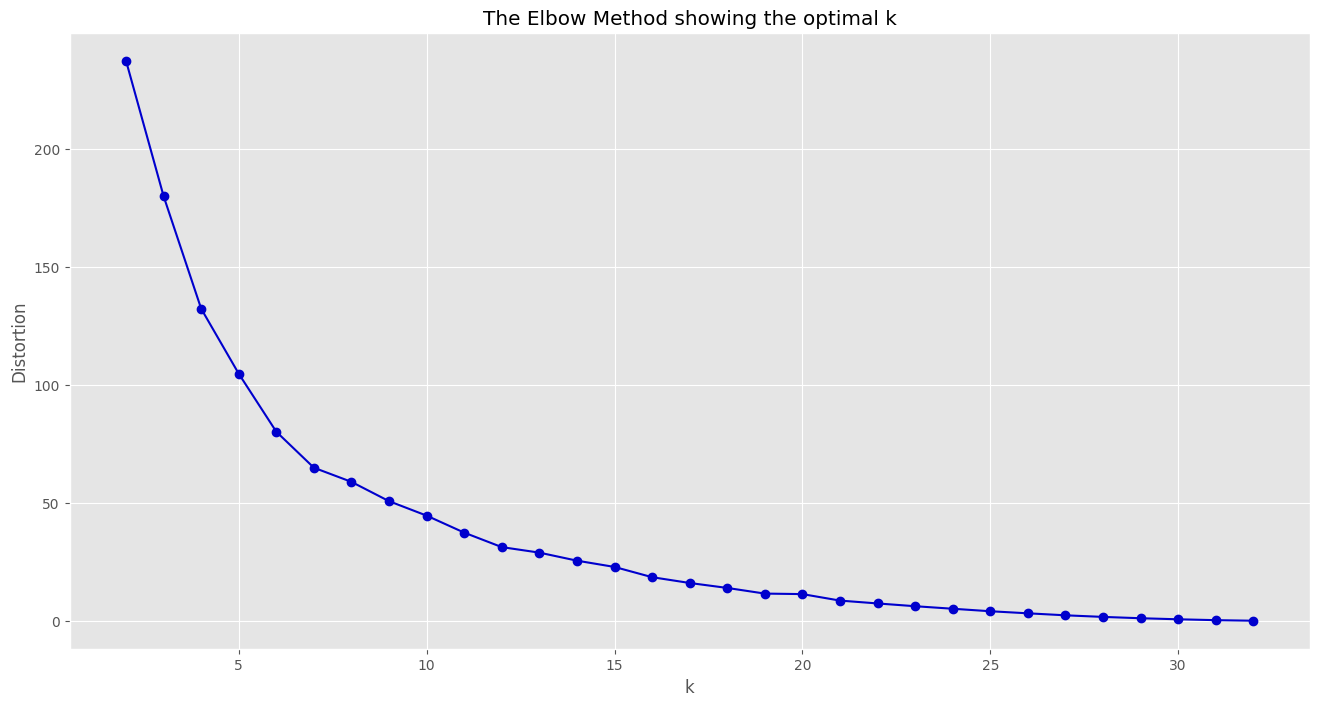

In [8]:
# Plotting the distortions of K-Means
plt.figure(figsize=(16,8))
plt.plot(K_list, distortions, marker='o', color='mediumblue')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [43]:
model = KMeans(n_clusters=7).fit(scaled_df)
pred = model.predict(scaled_df)

In [44]:
temp = df_clustering.copy()
temp['cluster'] = pred
temp

,location,degC_mean,RH%_mean,lux_mean,sum_ac,sum_light,sum_plug,sum_power,sum_ac_nextyear,sum_light_nextyear,sum_plug_nextyear,sum_power_nextyear,cluster
0,floor1_z1,26.113270,61.805960,23.278772,0.000000,112752.118021,73831.871424,1.865840e+05,0.000000,223065.787561,54505.483784,278276.559167,0
1,floor1_z2,25.830945,62.775074,19.655512,596616.103329,260201.601561,274167.557039,1.130985e+06,0.000000,223065.787561,54505.483784,278276.559167,3
2,floor1_z3,25.571807,64.222105,20.713771,0.000000,416407.807222,20560.448874,4.369683e+05,0.000000,223065.787561,54505.483784,278276.559167,0
3,floor1_z4,25.551109,63.721931,18.421033,0.000000,302137.521313,0.000000,3.021375e+05,0.000000,223065.787561,54505.483784,278276.559167,0
4,floor2_z1,25.344855,59.686863,28.292708,148711.397690,52662.818664,19206.692538,2.205809e+05,297798.519249,89970.119809,39091.375534,426910.892637,6
5,floor2_z2,26.573877,63.688610,23.462590,185757.062508,11180.733952,3356.450571,2.002942e+05,297798.519249,89970.119809,39091.375534,426910.892637,6
6,floor2_z3,28.194350,64.099893,2.373539,0.000000,9110.824076,6705.630358,1.581645e+04,297798.519249,89970.119809,39091.375534,426910.892637,5
7,floor2_z4,23.993496,63.510199,16.580911,48066.613805,12201.777703,0.461729,6.026885e+04,297798.519249,89970.119809,39091.375534,426910.892637,6
8,floor3_z1,26.434646,59.880090,11.923335,76812.409483,29016.405186,4169.843952,1.099987e+05,169874.273050,61187.116420,8815.760938,239872.009655,4
9,floor3_z2,25.980274,60.686979,26.539486,55289.633399,34715.598631,4845.928942,9.485116e+04,169874.273050,61187.116420,8815.760938,239872.009655,4


In [45]:
# temp.to_parquet(".\data_sample\df_clustered.parquet")
df = pd.read_parquet(".\data_sample\df_clustered.parquet")
df

,location,degC_mean,RH%_mean,lux_mean,sum_ac,sum_light,sum_plug,sum_power,sum_ac_nextyear,sum_light_nextyear,sum_plug_nextyear,sum_power_nextyear,cluster
0,floor1_z1,26.113270,61.805960,23.278772,0.000000,112752.118021,73831.871424,1.865840e+05,0.000000,223065.787561,54505.483784,278276.559167,0
1,floor1_z2,25.830945,62.775074,19.655512,596616.103329,260201.601561,274167.557039,1.130985e+06,0.000000,223065.787561,54505.483784,278276.559167,3
2,floor1_z3,25.571807,64.222105,20.713771,0.000000,416407.807222,20560.448874,4.369683e+05,0.000000,223065.787561,54505.483784,278276.559167,0
3,floor1_z4,25.551109,63.721931,18.421033,0.000000,302137.521313,0.000000,3.021375e+05,0.000000,223065.787561,54505.483784,278276.559167,0
4,floor2_z1,25.344855,59.686863,28.292708,148711.397690,52662.818664,19206.692538,2.205809e+05,297798.519249,89970.119809,39091.375534,426910.892637,6
5,floor2_z2,26.573877,63.688610,23.462590,185757.062508,11180.733952,3356.450571,2.002942e+05,297798.519249,89970.119809,39091.375534,426910.892637,6
6,floor2_z3,28.194350,64.099893,2.373539,0.000000,9110.824076,6705.630358,1.581645e+04,297798.519249,89970.119809,39091.375534,426910.892637,5
7,floor2_z4,23.993496,63.510199,16.580911,48066.613805,12201.777703,0.461729,6.026885e+04,297798.519249,89970.119809,39091.375534,426910.892637,6
8,floor3_z1,26.434646,59.880090,11.923335,76812.409483,29016.405186,4169.843952,1.099987e+05,169874.273050,61187.116420,8815.760938,239872.009655,4
9,floor3_z2,25.980274,60.686979,26.539486,55289.633399,34715.598631,4845.928942,9.485116e+04,169874.273050,61187.116420,8815.760938,239872.009655,4


In [46]:
df.loc[df['sum_light'] < 200_000]

,location,degC_mean,RH%_mean,lux_mean,sum_ac,sum_light,sum_plug,sum_power,sum_ac_nextyear,sum_light_nextyear,sum_plug_nextyear,sum_power_nextyear,cluster
0,floor1_z1,26.113270,61.805960,23.278772,0.000000,112752.118021,73831.871424,186583.989445,0.000000,223065.787561,54505.483784,278276.559167,0
4,floor2_z1,25.344855,59.686863,28.292708,148711.397690,52662.818664,19206.692538,220580.908893,297798.519249,89970.119809,39091.375534,426910.892637,6
5,floor2_z2,26.573877,63.688610,23.462590,185757.062508,11180.733952,3356.450571,200294.247030,297798.519249,89970.119809,39091.375534,426910.892637,6
6,floor2_z3,28.194350,64.099893,2.373539,0.000000,9110.824076,6705.630358,15816.454435,297798.519249,89970.119809,39091.375534,426910.892637,5
7,floor2_z4,23.993496,63.510199,16.580911,48066.613805,12201.777703,0.461729,60268.853237,297798.519249,89970.119809,39091.375534,426910.892637,6
8,floor3_z1,26.434646,59.880090,11.923335,76812.409483,29016.405186,4169.843952,109998.658621,169874.273050,61187.116420,8815.760938,239872.009655,4
9,floor3_z2,25.980274,60.686979,26.539486,55289.633399,34715.598631,4845.928942,94851.160972,169874.273050,61187.116420,8815.760938,239872.009655,4
10,floor3_z3,25.312937,67.839742,13.058812,0.000000,7645.673392,7403.224187,15048.897580,169874.273050,61187.116420,8815.760938,239872.009655,1
11,floor3_z4,25.043449,65.473478,9.315308,55484.477412,16810.839842,3370.874641,75666.191894,169874.273050,61187.116420,8815.760938,239872.009655,1
12,floor3_z5,24.368375,70.185339,10.385508,29210.377684,11040.855187,3678.923976,43930.156847,169874.273050,61187.116420,8815.760938,239872.009655,1


Text(0.5, 1.0, '3 dimensions clustering result')

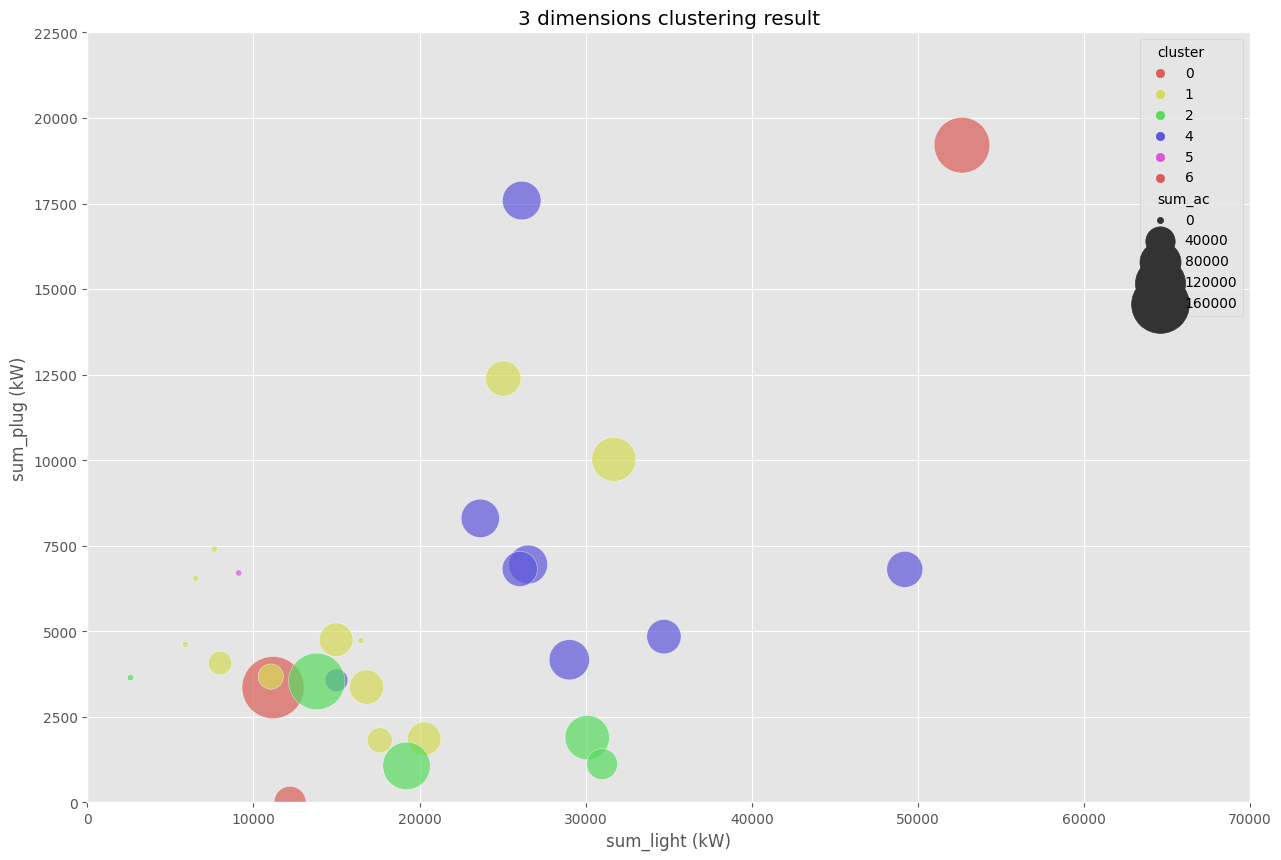

In [47]:
fig, ax = plt.subplots(figsize=(15, 10))
# plt.scatter(df_clustering.iloc[:, 5], df_clustering.iloc[:, 6], c=pred)
# plt.xticks(rotation=90)
sns.scatterplot(data=df.loc[df['sum_light'] < 200_000], 
                x='sum_light', y='sum_plug', 
                size='sum_ac', hue='cluster', 
                sizes=(20, 2000), palette='hls', alpha=0.7)
plt.xlim((0, 70_000))
plt.ylim((0, 22_500))
plt.xlabel('sum_light (kW)')
plt.ylabel('sum_plug (kW)')
plt.title('3 dimensions clustering result')